## Index

### (0) Preview of Accuracy Rates of All Models Built

### (1) SEED-VIG Dataset Loading and Analysis

### (2) LSTM

- a) Model Parameter Tuning
- b) Model after Parameter Tuning
- c) Testing and Evaluation

### (3) AdaboostM2

- a) Model Parameter Tuning & Testing and Evaluation

### (4) RNN

- a) Model Parameter Tuning
- b) Model after Parameter Tuning
- c) Testing and Evaluation


<h2>(0) Preview of Accuracy Rates of All Models Built</h2>

| Model Type | Model Accuracy |
|------------|----------------|
| LSTM       |    95.48%      |
| <span style="background-color: #FFFF00">AdaboostM2</span> |    <span style="background-color: #FFFF00">97.52%</span>      |
| RNN        |    95.53%      |

<h2>(1) SEED-VIG Dataset Loading and Analysis</h2>

Each subject file in perclos labels has 885 numbers indicating whether the EEG at that moment is either drowsy, tired or awake.

• Awake class: PERCLOS < 0.35;

• Tired class: 0.35 ≤ PERCLOS < 0.7;

• Drowsy class: PERCLOS ≥ 0.7.


**EEG_Feature_5Bands** folder was chosen for feeding into LSTM model. The following describes the file structure.

EEG features (PSD, DE) from five frequency bands:
- delta (1 C4 Hz)
- theta (4 C8 Hz)
- alpha (8 C14 Hz)
- beta (14 C31 Hz)
- gamma (31 C50 Hz)

And each of the following have the shape (17 * 885 * 5) -> channel * sample number * frequency bands:
- psd_movingAve -> PSD with moving average
- **psd_LDS** -> PSD with linear dynamic system
- de_movingAve -> DE with moving average
- **de_LDS** -> DE with linear dynamic system.

Features to feed into LSTM - three different possible ways:

◩ psd_LDS

◩ de_LDS

◩ psd_LDS concatenated with de_LDS as one feature set

The first 1-5 in the first dimension 'channel' are corresponding to temporal brain areas, and the last 7-17 are corresponding to posterior brain areas. The 1-5 in the third dimension 'frequency bands' are corresponding to delta (1 C4 Hz), theta (4 C8 Hz), alpha (8 C14 Hz), beta (14 C31 Hz), and gamma (31 C50 Hz).

Notes:
- PSD (Power Spectral Density) focuses on the **power distribution across frequency bands**, helping identify which frequencies are dominant.
- DE (Differential Entropy) focuses on the **complexity and unpredictability of the signal**, giving a sense of the signal's overall variability.

The following code block performs the loading of the data to form the numpy arrays that hold the dataset in a readable format.

- Each unit of training data is a single EEG sample, formatted as an array of shape (17, 10)

- There are 20355 EEG samples in total, and a 80:20 training-testing split is chosen - 16284 samples for training and 4071 for testing.

<h3>Feature Extraction</h3>
All frequency bands are extracted in the following code block.

In [1]:
import numpy as np
from glob import glob
from scipy.io import loadmat

# function to convert PERCLOS to labels
def convert_perclos_to_label(perclos_num):
    if perclos_num < 0.35:
        return 0 # awake
    if perclos_num >=0.35 and perclos_num < 0.7:
        return 1 # tired
    if perclos_num >=0.7:
        return 2 # drowsy

# load all file paths
all_file_paths = sorted(glob("EEG_Feature_5Bands/*.mat"))
all_label_file_paths = sorted(glob("perclos_labels/*.mat"))
all_labels = np.empty((20355,1)) # initialize arrays to store labels and features
features = np.empty((20355, 17, 10))

data_count = 0  # init data_count outside the loop
for file_num in range(23): # process each file
    file_array = loadmat(all_file_paths[file_num])['psd_LDS'] # (17, 885, 5)
    file_array2 = loadmat(all_file_paths[file_num])['de_LDS']  # (17, 885, 5)
    labels_array = loadmat(all_label_file_paths[file_num])['perclos'] #(885, 1)
    for sample in range(885):
        all_labels[data_count] = convert_perclos_to_label(labels_array[sample])
        for channel in range(17):
            features[data_count, channel] = np.concatenate((file_array[channel, sample], file_array2[channel, sample]))
        data_count += 1  # increment data_count after each sample

# verify shapes of the arrays
print(f"Features shape: {features.shape}")
print(f"Labels shape: {all_labels.shape}")


Features shape: (20355, 17, 10)
Labels shape: (20355, 1)


<h3>Feature Extraction Ver. 2</h3>
The following code block extracts only theta and delta frequency bands' data from the EEG samples.

In [2]:
import numpy as np
from glob import glob
from scipy.io import loadmat

# function to convert PERCLOS to labels
def convert_perclos_to_label(perclos_num):
    if perclos_num < 0.35:
        return 0 # awake
    if perclos_num >=0.35 and perclos_num < 0.7:
        return 1 # tired
    if perclos_num >=0.7:
        return 2 # drowsy

# load all file paths
all_file_paths = sorted(glob("EEG_Feature_5Bands/*.mat"))
all_label_file_paths = sorted(glob("perclos_labels/*.mat"))
all_labels = np.empty((20355,1)) # initialize arrays to store labels and features
features = np.empty((20355, 17, 4))

data_count = 0  # init data_count outside the loop
for file_num in range(23): # process each file
    file_array = loadmat(all_file_paths[file_num])['psd_LDS'][:, :, :2] # (17, 885, 2)
    file_array2 = loadmat(all_file_paths[file_num])['de_LDS'][:, :, :2]  # (17, 885, 2)
    labels_array = loadmat(all_label_file_paths[file_num])['perclos'] #(885, 1)
    for sample in range(885):
        all_labels[data_count] = convert_perclos_to_label(labels_array[sample])
        for channel in range(17):
            features[data_count, channel] = np.concatenate((file_array[channel, sample], file_array2[channel, sample]))
        data_count += 1  # increment data_count after each sample

# verify shapes of the arrays
print(f"Features shape: {features.shape}")
print(f"Labels shape: {all_labels.shape}")


Features shape: (20355, 17, 4)
Labels shape: (20355, 1)


<h2>(2) LSTM</h2>

<h3> a) Model Parameter Tuning</h3>

- Different optimizers, learning rates, drop out rates, and activation functions were tested. Additionally, number of layers were initially around 5 to 6 layers with accompanying drop out layers, unwanted layers were identified iteratively and removed while monitoring accuracy level.
- best optimizer: Adamax
- best drop out rate: 0.02
- best learning rate: 0.01
- best activation function: tanh

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# checks labels are integers and normalize features
all_labels = np.array(all_labels, dtype=int)
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.2, random_state=42)

optimizer_constructors = { # list of optimizers to test
    'adam': tf.keras.optimizers.Adam,
    'sgd': tf.keras.optimizers.SGD,
    'rmsprop': tf.keras.optimizers.RMSprop,
    'adamax': tf.keras.optimizers.Adamax,
    'nadam': tf.keras.optimizers.Nadam
}

learning_rates = [0.01, 0.001, 0.0001] # learning rates to test
# start parameter tuning
for opt_name, opt_constructor in optimizer_constructors.items():
    for lr in learning_rates:
        print(f"Training with {opt_name} optimizer and learning rate {lr}...")
        
        model = models.Sequential()
        model.add(layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(17, 10)))
        model.add(layers.Dropout(0.2))
        model.add(layers.LSTM(64, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))
        
        optimizer = opt_constructor(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
        # evaluate the model on test data
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
        print(f"\nTest accuracy with {opt_name} optimizer and learning rate {lr}: {test_acc}\n")


Training with adam optimizer and learning rate 0.01...
Epoch 1/30
509/509 [==============================] - 35s 53ms/step - loss: 0.8832 - accuracy: 0.5653 - val_loss: 0.6471 - val_accuracy: 0.7224
Epoch 2/30
509/509 [==============================] - 26s 51ms/step - loss: 0.9057 - accuracy: 0.5591 - val_loss: 0.7874 - val_accuracy: 0.6532
Epoch 3/30
509/509 [==============================] - 26s 51ms/step - loss: 1.1921 - accuracy: 0.5306 - val_loss: 0.8652 - val_accuracy: 0.5264
Epoch 4/30
509/509 [==============================] - 26s 51ms/step - loss: 0.9131 - accuracy: 0.5181 - val_loss: 0.8216 - val_accuracy: 0.5817
Epoch 5/30
509/509 [==============================] - 26s 51ms/step - loss: 0.8661 - accuracy: 0.5499 - val_loss: 0.7734 - val_accuracy: 0.5937
Epoch 6/30
509/509 [==============================] - 26s 51ms/step - loss: 0.8386 - accuracy: 0.5685 - val_loss: 0.7285 - val_accuracy: 0.6473
Epoch 7/30
509/509 [==============================] - 26s 51ms/step - loss: 0.816

Epoch 26/30
509/509 [==============================] - 20s 40ms/step - loss: 0.2235 - accuracy: 0.9210 - val_loss: 0.2175 - val_accuracy: 0.9148
Epoch 27/30
509/509 [==============================] - 20s 40ms/step - loss: 0.2065 - accuracy: 0.9261 - val_loss: 0.1899 - val_accuracy: 0.9273
Epoch 28/30
509/509 [==============================] - 19s 37ms/step - loss: 0.1770 - accuracy: 0.9317 - val_loss: 0.1838 - val_accuracy: 0.9320
Epoch 29/30
509/509 [==============================] - 20s 39ms/step - loss: 0.2088 - accuracy: 0.9304 - val_loss: 0.2293 - val_accuracy: 0.9172
Epoch 30/30
509/509 [==============================] - 20s 40ms/step - loss: 0.1732 - accuracy: 0.9328 - val_loss: 0.1926 - val_accuracy: 0.9327
128/128 - 2s - loss: 0.1926 - accuracy: 0.9327 - 2s/epoch - 17ms/step

Test accuracy with adam optimizer and learning rate 0.001: 0.932694673538208

Training with adam optimizer and learning rate 0.0001...
Epoch 1/30
509/509 [==============================] - 33s 50ms/step -

509/509 [==============================] - 17s 34ms/step - loss: 1.0659 - accuracy: 0.4559 - val_loss: 1.0617 - val_accuracy: 0.4699
Epoch 15/30
509/509 [==============================] - 16s 31ms/step - loss: 1.0644 - accuracy: 0.4577 - val_loss: 1.0596 - val_accuracy: 0.4682
Epoch 16/30
509/509 [==============================] - 26s 51ms/step - loss: 1.0619 - accuracy: 0.4589 - val_loss: 1.0577 - val_accuracy: 0.4675
Epoch 17/30
509/509 [==============================] - 27s 52ms/step - loss: 1.0598 - accuracy: 0.4563 - val_loss: 1.0558 - val_accuracy: 0.4711
Epoch 18/30
509/509 [==============================] - 27s 52ms/step - loss: 1.0583 - accuracy: 0.4576 - val_loss: 1.0539 - val_accuracy: 0.4714
Epoch 19/30
509/509 [==============================] - 27s 52ms/step - loss: 1.0569 - accuracy: 0.4622 - val_loss: 1.0521 - val_accuracy: 0.4733
Epoch 20/30
509/509 [==============================] - 27s 53ms/step - loss: 1.0545 - accuracy: 0.4624 - val_loss: 1.0504 - val_accuracy: 0.47

Epoch 8/30
509/509 [==============================] - 38s 74ms/step - loss: 0.4119 - accuracy: 0.8522 - val_loss: 0.6316 - val_accuracy: 0.8538
Epoch 9/30
509/509 [==============================] - 38s 74ms/step - loss: 0.4052 - accuracy: 0.8588 - val_loss: 0.3351 - val_accuracy: 0.8681
Epoch 10/30
509/509 [==============================] - 38s 74ms/step - loss: 0.3658 - accuracy: 0.8654 - val_loss: 1.2838 - val_accuracy: 0.8664
Epoch 11/30
509/509 [==============================] - 38s 74ms/step - loss: 0.5580 - accuracy: 0.8726 - val_loss: 0.3257 - val_accuracy: 0.8698
Epoch 12/30
509/509 [==============================] - 38s 74ms/step - loss: 0.3559 - accuracy: 0.8747 - val_loss: 0.3215 - val_accuracy: 0.8745
Epoch 13/30
509/509 [==============================] - 38s 74ms/step - loss: 0.3358 - accuracy: 0.8842 - val_loss: 0.3214 - val_accuracy: 0.8730
Epoch 14/30
509/509 [==============================] - 36s 70ms/step - loss: 0.4801 - accuracy: 0.8875 - val_loss: 0.3726 - val_accu

509/509 [==============================] - 47s 93ms/step - loss: 0.3053 - accuracy: 0.8706 - val_loss: 0.2836 - val_accuracy: 0.8730
Epoch 27/30
509/509 [==============================] - 48s 93ms/step - loss: 0.3617 - accuracy: 0.8742 - val_loss: 0.2783 - val_accuracy: 0.8723
Epoch 28/30
509/509 [==============================] - 42s 83ms/step - loss: 0.2801 - accuracy: 0.8820 - val_loss: 0.2790 - val_accuracy: 0.8791
Epoch 29/30
509/509 [==============================] - 41s 81ms/step - loss: 0.2770 - accuracy: 0.8785 - val_loss: 0.2781 - val_accuracy: 0.8767
Epoch 30/30
509/509 [==============================] - 51s 100ms/step - loss: 0.2759 - accuracy: 0.8833 - val_loss: 0.2648 - val_accuracy: 0.8804
128/128 - 1s - loss: 0.2648 - accuracy: 0.8804 - 1s/epoch - 10ms/step

Test accuracy with adamax optimizer and learning rate 0.001: 0.8803733587265015

Training with adamax optimizer and learning rate 0.0001...
Epoch 1/30
509/509 [==============================] - 47s 86ms/step - loss:

509/509 [==============================] - 60s 118ms/step - loss: 0.4755 - accuracy: 0.8017 - val_loss: 0.4442 - val_accuracy: 0.8121
Epoch 13/30
509/509 [==============================] - 64s 126ms/step - loss: 0.4682 - accuracy: 0.8052 - val_loss: 0.4565 - val_accuracy: 0.8072
Epoch 14/30
509/509 [==============================] - 52s 102ms/step - loss: 0.4581 - accuracy: 0.8098 - val_loss: 0.4260 - val_accuracy: 0.8231
Epoch 15/30
509/509 [==============================] - 61s 120ms/step - loss: 0.4465 - accuracy: 0.8152 - val_loss: 0.4412 - val_accuracy: 0.8101
Epoch 16/30
509/509 [==============================] - 59s 116ms/step - loss: 0.4388 - accuracy: 0.8180 - val_loss: 0.4144 - val_accuracy: 0.8222
Epoch 17/30
509/509 [==============================] - 57s 112ms/step - loss: 0.4334 - accuracy: 0.8169 - val_loss: 0.4042 - val_accuracy: 0.8241
Epoch 18/30
509/509 [==============================] - 45s 89ms/step - loss: 0.4283 - accuracy: 0.8215 - val_loss: 0.4106 - val_accuracy

<h3> b) Model After Parameter Tuning</h3>

- with optimal parameter values, the accuracy improved significantly.
- early stopping was implemented to regulate the number of epochs to avoid overfitting.
- number of layers were reduced incrementally until change in accuracy was negative.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = np.array(all_labels, dtype=int)  # make sure labels are integers - suitable for classification
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)  # normalize features to have zero mean and unit variance
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.2, random_state=42)  # split data into training and testing sets

model = models.Sequential()
model.add(layers.LSTM(128, activation='tanh', return_sequences=True, input_shape=(17, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())  # flatten output before passing it to the next dense layer
model.add(layers.Dense(3, activation='softmax'))  # final output layer for 3 classes
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # can also use 'val_accuracy'
    patience=5,                # number of epochs to wait for improvement
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
509/509 [==============================] - 17s 28ms/step - loss: 0.7354 - accuracy: 0.6625 - val_loss: 0.5951 - val_accuracy: 0.7384
Epoch 2/30
509/509 [==============================] - 14s 28ms/step - loss: 0.5819 - accuracy: 0.7490 - val_loss: 0.6178 - val_accuracy: 0.7367
Epoch 3/30
509/509 [==============================] - 14s 27ms/step - loss: 0.5428 - accuracy: 0.7648 - val_loss: 0.5038 - val_accuracy: 0.7770
Epoch 4/30
509/509 [==============================] - 13s 26ms/step - loss: 0.4973 - accuracy: 0.7870 - val_loss: 0.4653 - val_accuracy: 0.7939
Epoch 5/30
509/509 [==============================] - 14s 27ms/step - loss: 0.4565 - accuracy: 0.8052 - val_loss: 0.4185 - val_accuracy: 0.8192
Epoch 6/30
509/509 [==============================] - 14s 27ms/step - loss: 0.4245 - accuracy: 0.8202 - val_loss: 0.4173 - val_accuracy: 0.8172
Epoch 7/30
509/509 [==============================] - 14s 27ms/step - loss: 0.3902 - accuracy: 0.8347 - val_loss: 0.3467 - val_accuracy:

<h3> c) Testing and Evaluation</h3>

- confusion matrix, classification report when the data was tested on remaining 30% data

In [5]:
# evaluation + report for analysis of model performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
y_pred = model.predict(X_test) # use test set to predict
y_pred_classes = np.argmax(y_pred, axis=1)
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

128/128 [==============================] - 1s 4ms/step - loss: 0.1263 - accuracy: 0.9585
Test Accuracy: 95.85%
128/128 [==============================] - 1s 4ms/step
Confusion Matrix:
[[1429   69    0]
 [  58 1694   11]
 [   0   31  779]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1498
           1       0.94      0.96      0.95      1763
           2       0.99      0.96      0.97       810

    accuracy                           0.96      4071
   macro avg       0.96      0.96      0.96      4071
weighted avg       0.96      0.96      0.96      4071



<h2>(3) AdaBoostM2</h2>

<h3>Model Parameter Tuning & Testing and Evaluation</h3>

- Number of decision stumps were increased iteratively - 1000 n_estimators was the optimal value.

In [8]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

flattened_features = features.reshape(20355, -1) # new shape is (20355, 170)
X_train, X_test, y_train, y_test = train_test_split(flattened_features, all_labels, test_size=0.3, random_state=42)
base_estimator = DecisionTreeClassifier()
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=1000, random_state=42)
adaboost.fit(X_train, y_train.flatten())

# make predictions with remaining 30% of data
y_pred = adaboost.predict(X_test)
accuracy = accuracy_score(y_test.flatten(), y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test.flatten(), y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:\n", classification_report(y_test.flatten(), y_pred))


Accuracy: 0.9703618798100541
Confusion Matrix:
[[2145   54    0]
 [  75 2581   28]
 [   0   24 1200]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2199
           1       0.97      0.96      0.97      2684
           2       0.98      0.98      0.98      1224

    accuracy                           0.97      6107
   macro avg       0.97      0.97      0.97      6107
weighted avg       0.97      0.97      0.97      6107



<h2>(4) RNN</h2>

<h3>a) Model Parameter Tuning</h3>

- Automated parameter tuning was carried out for optimizers and learning rates, drop out rates and activation functions were tested manually.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# data normalisation
all_labels = np.array(all_labels, dtype=int)
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.2, random_state=42)

optimizer_constructors = {
    'adam': tf.keras.optimizers.Adam,
    'rmsprop': tf.keras.optimizers.RMSprop,
    'adamax': tf.keras.optimizers.Adamax,
    'nadam': tf.keras.optimizers.Nadam
}
learning_rates = [0.001]
for opt_name, opt_constructor in optimizer_constructors.items():
    for lr in learning_rates:
        print(f"Training with {opt_name} optimizer and learning rate {lr}...")
        
        model = models.Sequential()
        model.add(layers.SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(17, 10)))
        model.add(layers.Dropout(0.2))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        optimizer = opt_constructor(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        history = model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping]
        )
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
        print(f"\nTest accuracy with {opt_name} optimizer and learning rate {lr}: {test_acc}\n")


Training with adam optimizer and learning rate 0.001...
Epoch 1/30
509/509 [==============================] - 8s 13ms/step - loss: 0.5475 - accuracy: 0.7677 - val_loss: 0.4564 - val_accuracy: 0.8155
Epoch 2/30
509/509 [==============================] - 6s 13ms/step - loss: 0.4278 - accuracy: 0.8266 - val_loss: 0.3877 - val_accuracy: 0.8529
Epoch 3/30
509/509 [==============================] - 7s 13ms/step - loss: 0.3668 - accuracy: 0.8549 - val_loss: 0.3003 - val_accuracy: 0.8762
Epoch 4/30
509/509 [==============================] - 7s 13ms/step - loss: 0.3382 - accuracy: 0.8654 - val_loss: 0.3036 - val_accuracy: 0.8944
Epoch 5/30
509/509 [==============================] - 7s 13ms/step - loss: 0.3033 - accuracy: 0.8821 - val_loss: 0.2793 - val_accuracy: 0.8922
Epoch 6/30
509/509 [==============================] - 7s 13ms/step - loss: 0.2754 - accuracy: 0.8959 - val_loss: 0.2473 - val_accuracy: 0.9101
Epoch 7/30
509/509 [==============================] - 7s 13ms/step - loss: 0.2486 - ac

Epoch 10/30
509/509 [==============================] - 8s 15ms/step - loss: 0.2239 - accuracy: 0.9123 - val_loss: 0.2148 - val_accuracy: 0.9162
Epoch 11/30
509/509 [==============================] - 8s 15ms/step - loss: 0.2050 - accuracy: 0.9223 - val_loss: 0.2117 - val_accuracy: 0.9192
Epoch 12/30
509/509 [==============================] - 7s 14ms/step - loss: 0.1941 - accuracy: 0.9272 - val_loss: 0.2241 - val_accuracy: 0.9123
Epoch 13/30
509/509 [==============================] - 8s 15ms/step - loss: 0.1854 - accuracy: 0.9267 - val_loss: 0.1956 - val_accuracy: 0.9280
Epoch 14/30
509/509 [==============================] - 7s 13ms/step - loss: 0.1713 - accuracy: 0.9367 - val_loss: 0.2119 - val_accuracy: 0.9165
Epoch 15/30
509/509 [==============================] - 7s 13ms/step - loss: 0.1660 - accuracy: 0.9389 - val_loss: 0.1988 - val_accuracy: 0.9248
Epoch 16/30
509/509 [==============================] - 4s 9ms/step - loss: 0.1564 - accuracy: 0.9406 - val_loss: 0.1723 - val_accuracy: 

<h3> b) Model results after parameter tuning</h3>

- best optimizer: adamax

- best drop out rate: 0.2

- best learning rate: 0.001

- best activation function: relu

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = np.array(all_labels, dtype=int) 
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.2, random_state=42)
model = models.Sequential()
model.add(layers.SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(17, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
509/509 [==============================] - 6s 8ms/step - loss: 0.7365 - accuracy: 0.6767 - val_loss: 0.6041 - val_accuracy: 0.7465
Epoch 2/30
509/509 [==============================] - 6s 12ms/step - loss: 0.5857 - accuracy: 0.7518 - val_loss: 0.5321 - val_accuracy: 0.7856
Epoch 3/30
509/509 [==============================] - 5s 10ms/step - loss: 0.5251 - accuracy: 0.7814 - val_loss: 0.4801 - val_accuracy: 0.8057
Epoch 4/30
509/509 [==============================] - 5s 10ms/step - loss: 0.4842 - accuracy: 0.7978 - val_loss: 0.4503 - val_accuracy: 0.8168
Epoch 5/30
509/509 [==============================] - 5s 10ms/step - loss: 0.4504 - accuracy: 0.8136 - val_loss: 0.4212 - val_accuracy: 0.8325
Epoch 6/30
509/509 [==============================] - 5s 11ms/step - loss: 0.4187 - accuracy: 0.8292 - val_loss: 0.4163 - val_accuracy: 0.8298
Epoch 7/30
509/509 [==============================] - 5s 11ms/step - loss: 0.3863 - accuracy: 0.8433 - val_loss: 0.3752 - val_accuracy: 0.8455


<h3>c) Testing and Evaluation</h3>

In [11]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

128/128 [==============================] - 1s 7ms/step - loss: 0.1708 - accuracy: 0.9428
Test Accuracy: 94.28%
Confusion Matrix:
[[1385  113    0]
 [  54 1684   25]
 [   0   41  769]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1498
           1       0.92      0.96      0.94      1763
           2       0.97      0.95      0.96       810

    accuracy                           0.94      4071
   macro avg       0.95      0.94      0.95      4071
weighted avg       0.94      0.94      0.94      4071



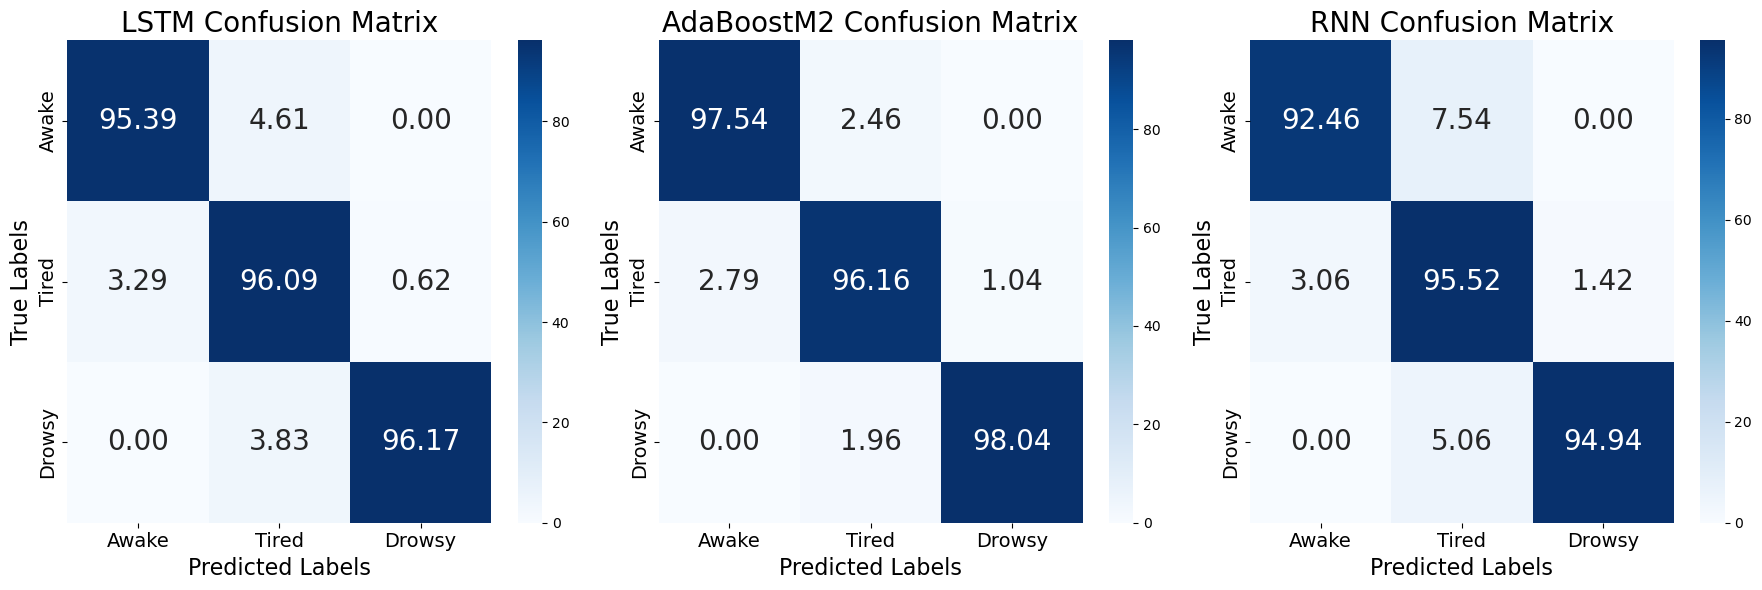

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrices
conf_matrices = {
    "LSTM": np.array([[1429,  69,   0],
                      [  58, 1694,  11],
                      [   0,   31,  779]]),
    
    "AdaBoostM2": np.array([[2145,  54,   0],
                            [  75, 2581,  28],
                            [   0,   24, 1200]]),
    
    "RNN": np.array([[1385, 113,   0],
                     [  54, 1684,  25],
                     [   0,   41,  769]])
}

# Convert confusion matrices to percentages
conf_matrices_percent = {key: (value.astype(float) / value.sum(axis=1)[:, np.newaxis]) * 100
                         for key, value in conf_matrices.items()}

# Define labels
labels = ["Awake", "Tired", "Drowsy"]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (key, matrix) in zip(axes, conf_matrices_percent.items()):
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, 
                ax=ax, annot_kws={"size": 20})  # annotation font size
    ax.set_title(f"{key} Confusion Matrix", fontsize=20)  # title font size
    ax.set_xlabel("Predicted Labels", fontsize=16)  # x-axis label font size
    ax.set_ylabel("True Labels", fontsize=16)  # y-axis label font size
    ax.tick_params(axis='x', labelsize=14)  # x-tick labels font size
    ax.tick_params(axis='y', labelsize=14)  # y-tick labels font size

plt.tight_layout()
plt.show()
